In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import math
import numpy as np
import scipy.stats as stats


Define the distribution that we will learn

In [23]:
data_mean = 10
data_stddev =  math.sqrt(2)
Series_Length = 50

Define the shape of the generator

Takes 20 random inputs and generates a distribution (as defined above)
Hidden layer neuron count is defined. 

In [24]:
g_input_size = 20    
g_hidden_size = 150  
g_output_size = Series_Length  

Define the shape of the discrimiator network

output is one value 
- True (1.0) matches desired distribution
- False (0.0) does not match the distribution

In [25]:
d_input_size = Series_Length
d_hidden_size = 75   
d_output_size = 1

Now define how to send data into the process

There are two phases of training, train the discriminator
then the generator. It seems to be important that the discriminator 
be 'better' than the generator. Sometimes more batches are sent to
train the discriminator than the generator. In this case we 
put more stuff into the discriminator training.

In [26]:
d_minibatch_size = 15 
g_minibatch_size = 10

num_epochs = 10000
print_interval = 1000

Setting learning rates

In [27]:
d_learning_rate = 1e-3
g_learning_rate = 1e-2

Define two functions to return functions that provide
a true sample and some random noise. The true sample
trains the discriminator, the random noise feeds the 
generator.

Make local copies of the signal generator functions

In [28]:
def get_real_sampler(mu, sigma):
    dist = Normal( mu, sigma )
    return lambda m, n: dist.sample( (m, n) ).requires_grad_()

def get_noise_sampler():
    return lambda m, n: torch.rand(m, n).requires_grad_()  # Uniform-dist data into generator, _NOT_ Gaussian

actual_data = get_real_sampler( data_mean, data_stddev )
noise_data  = get_noise_sampler()

Define the generator 

It's important the generator can output means that match. Be careful
using something like sigmoid, which outputs 0..1. That would not learn
something with mean 2.0 !

This network takes in noise
and produces an output.

xfer is the transfer function

In [29]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, hidden_size)
        self.map5 = nn.Linear(hidden_size, hidden_size)
        self.map6 = nn.Linear(hidden_size, output_size)
        self.xfer = torch.nn.SELU()

    def forward(self, x):
        x = self.xfer( self.map1(x) )
        x = self.xfer( self.map2(x) )
        x = self.xfer( self.map3(x) )
        x = self.xfer( self.map4(x) )
        x = self.xfer( self.map5(x) )
        return self.xfer( self.map6( x ) )

Note the last layer should restrict to 0..1 (opposite of the generator)
This allows us more choice in loss functions.

This network is a classic multilayer perceptron - really nothing
special at all. It returns true/false based on the learned
function.

In [30]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, output_size)
        self.elu = torch.nn.ELU()

    def forward(self, x):
        x = self.elu(self.map1(x))
        x = self.elu(self.map2(x))
        x = self.elu(self.map3(x))
        return torch.sigmoid( self.map4(x) )

Instantiate generator and discriminator

In [31]:
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)

Define loss function and optimiser object for generator and discriminator

In [32]:
criterion = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate ) #, betas=optim_betas)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate ) #, betas=optim_betas)

This fires in real data and learns a 1.0 mapping

In [33]:
def train_D_on_actual() :
    real_data = actual_data(d_minibatch_size, d_input_size)
    decision = D(real_data)
    error = criterion(decision, torch.ones( d_minibatch_size, 1 ))  # ones = true
    error.backward() 

The other side of training: learn to recognize fake output from
the generator.

In [34]:
def train_D_on_generated() :
    noise = noise_data( d_minibatch_size, g_input_size )
    fake_data = G( noise ) 
    decision = D( fake_data )
    error = criterion( decision, torch.zeros( d_minibatch_size, 1 ))  # zeros = fake
    error.backward()

The training for the generator is to assume that the generator
produces perfect data (i.e. the discriminator returns 1.0).
Then learn how to improve the output from the generator based on the discriminators actual output.

This is the key piece of a GAN:
pass the error through both networks, but only update the generators
weights.

In [35]:
def train_G():
    noise = noise_data( g_minibatch_size, g_input_size )
    fake_data = G( noise )
    fake_decision = D( fake_data )
    error = criterion( fake_decision, torch.ones( g_minibatch_size, 1 ) )  # we want to fool, so pretend it's all genuine

    error.backward()
    return error.item(), fake_data

The main loop, train based on loads of data.

The algo works like this:
    
Step 1 is plain old batch learning, if the rest of the code were
removed you would have a network that can identify the desired distribution

- train the discriminator just like you would train any network
- use both true and false (generated) samples to learn

Step 2 is the GAN difference
- train the generator to produce, but don't compare the output to a good sample
- feed the sample generated output through the disciminator to spot the fake
- backpropagate the error through the discriminator and the generator

So let's think about the possible cases (in *all* cases only the generators parameters 
are updated in the step 2)

*Discrimator perfect, Generator Perfect*
Generator makes a sample which is identified as 1.0. Error is 0.0, no learning occurs

*Discrimator perfect, Generator Rubbish*
Generator makes noise which is identified as 0.0. Error is 1.0, error is propagated and the generator learns

*Discrimator rubbish, Generator Perfect*
Generator makes sample which is identified as 0.0. Error is 1.0, error is propagated the generator would not learn much because the error would be absorbed by the discriminator

*Discrimator rubbish, Generator Rubbish*
Generator makes sample which is identified as 0.5. Error is 0.5, error is propagated the gradients in the discriminator and generator would mean the error is shared between both
and learning occurs

### This step can be slow - depending on the compute power available


In [36]:
losses = []

for epoch in range(num_epochs):
    D.zero_grad()
    
    train_D_on_actual()    
    train_D_on_generated()
    d_optimizer.step()
    
    G.zero_grad()
    loss,generated = train_G()
    g_optimizer.step()
    
    losses.append( loss )
    if( epoch % print_interval) == (print_interval-1) :
        print( "Epoch %6d,    Loss = %5.3f" % ( epoch+1, loss ) )
        
print( "Training complete" )
print(generated)
print(generated.size())

Epoch   1000,    Loss = 0.683
Epoch   2000,    Loss = 0.695
Epoch   3000,    Loss = 0.695
Epoch   4000,    Loss = 0.689
Epoch   5000,    Loss = 0.689
Epoch   6000,    Loss = 0.701
Epoch   7000,    Loss = 0.695
Epoch   8000,    Loss = 0.689
Epoch   9000,    Loss = 0.704
Epoch  10000,    Loss = 0.697
Training complete
tensor([[ 9.4846,  9.4300,  9.0296, 11.2812, 12.8647,  7.2811,  9.6237,  8.5173,
         10.0280, 11.2249, 11.7082, 10.0269, 10.3921, 10.3471, 13.7887,  7.8131,
          9.4445,  9.0909,  8.2406,  8.4970,  9.0126, 10.9040, 11.5191,  9.5405,
         10.3389,  7.7251, 12.0268,  9.7665, 10.2738,  8.7125,  8.3429, 12.5869,
         11.5284, 11.1849, 10.9903,  6.8662,  9.1722, 12.0431, 11.0173, 11.7385,
         10.5484,  7.2829, 12.3597, 13.3446, 10.1423, 12.1529,  8.5936,  9.0878,
         11.3304, 11.3980],
        [ 9.0087,  8.9462,  8.7603, 10.8315, 12.2128,  6.9615,  9.1006,  8.0046,
          9.5126, 10.8294, 11.0811,  9.5395,  9.9434,  9.9451, 13.0476,  7.4249,
      

After training everything we'll generate some samples and draw them. It's easy enough
to see that we have something like a nice normal distribution.
This step is entirely optional but it's nice to see what we did actually worked.

In [37]:
demo_length = 100

d = torch.empty( generated.size(0), demo_length ) 

#print(generated)

In [38]:
import matplotlib.pyplot as plt

def draw( data ) :    
    plt.figure(figsize=(10,5))
    
    #generated distributions
    generated_distributions = data.tolist() if isinstance(data, torch.Tensor) else data
    plt.plot(generated_distributions)

    #plotting normal distribution with correct parameters for reference
    original=torch.empty(demo_length).normal_(mean=data_mean,std=data_stddev)
    original_histogram = torch.histc( original, min=0, max=30, bins=demo_length )
    plt.plot(original_histogram, linewidth=3)
    
    #plt.xticks(ticks = [1, 2, 3], labels = ['0', '1', '2'])
    
    plt.show()

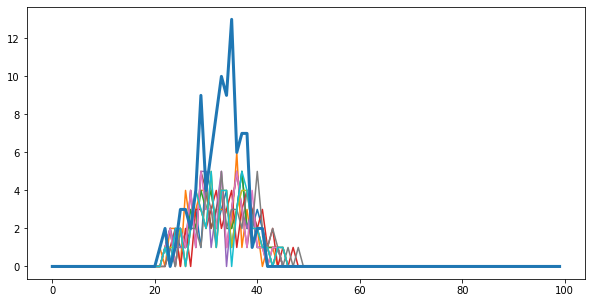

In [39]:
for i in range( 0, d.size(0) ) :
    d[i] = torch.histc( generated[i], min=0, max=30, bins=demo_length )
    
draw( d.t() )

In [40]:
d

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 2., 1., 1., 2., 3., 1., 5., 4., 2., 3., 4., 1.,
         3., 5., 2., 2., 3., 2., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 2., 2., 0., 4., 2., 3., 4., 4., 2., 3., 3., 3., 2.,
         6., 1., 3., 1., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

In [41]:
torch.mean(d)

tensor(0.5000, grad_fn=<MeanBackward0>)

In [42]:
d.size()


torch.Size([10, 100])